# Titanic Dataset


This dataset contains the passenger data of the Titanic voyage and the survival info. Aim is to predict the survival of the people


VARIABLE DESCRIPTIONS:

survival    :    Survival (0 = No; 1 = Yes)

pclass      :   Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

name        :    Name

sex         :    Sex

age         :    Age

sibsp       :    Number of Siblings/Spouses Aboard

parch       :    Number of Parents/Children Aboard

ticket      :    Ticket Number

fare        :    Passenger Fare

cabin       :    Cabin

embarked    :    Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [47]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import pylab as pyl
from operator import itemgetter

In [3]:
trainCsv = pd.read_csv(u'train.csv',sep=',')
testCsv = pd.read_csv(u'test.csv',sep=',')

In [4]:
trainCsv[0:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [5]:
#replacing missing ages with average age
def HandleAge(x):
    counter = 0.0
    sumX = 0.0
    for i in range(len(x)):
        if np.isnan(x[i]):
            continue
        sumX += x[i]
        counter += 1
    avg = round(sumX/counter,2)
    for i in range(len(x)):
        if np.isnan(x[i]):
            x[i] = avg
    return x


def HandleSex(x):
    y = np.zeros((len(x)))
    for i in range(len(x)):
        if x[i] == 'female':
            y[i] = 1
    return y

def HandleEmbarked(x):
    y = np.zeros((len(x),3))
    for i in range(len(x)):
        if x[i] == 'C':
            y[i,0] = 1
        elif x[i] == "Q":
            y[i,1] = 1
        else:
            y[i,2] = 1
    return y

In [6]:
trainMat = np.array(np.vstack((trainCsv.Pclass[0:],trainCsv.Sex[0:],trainCsv.Age[0:],trainCsv.SibSp[0:],
                     trainCsv.Parch[0:],trainCsv.Fare[0:],trainCsv.Embarked[0:])).T)
trainMat[:,2] = HandleAge(trainMat[:,2])
trainMat[:,1] = HandleSex(trainMat[:,1])
A_all = np.mat(np.hstack((trainMat[:,0:-1],HandleEmbarked(trainMat[:,6])))).astype(float)
y_all = np.mat(trainCsv.Survived[0:]).T

testMat = np.array(np.vstack((testCsv.Pclass[0:],testCsv.Sex[0:],testCsv.Age[0:],testCsv.SibSp[0:],
                     testCsv.Parch[0:],testCsv.Fare[0:],testCsv.Embarked[0:])).T)
testMat[:,2] = HandleAge(testMat[:,2])
testMat[:,1] = HandleSex(testMat[:,1])
A_test = np.mat(np.hstack((testMat[:,0:-1],HandleEmbarked(testMat[:,6])))).astype(float)
test_ids = np.mat(testCsv.PassengerId[0:]).astype(int).T

In [7]:
trainCount = int(len(A_all)*0.8)
AyAll = np.hstack((y_all,A_all))
np.random.shuffle(AyAll)

A_train = AyAll[0:trainCount,1:]
y_train = AyAll[0:trainCount,0]

A_cv = AyAll[trainCount:,1:]
y_cv = AyAll[trainCount:,0]

# Dimension Reduction and visualization

In [8]:
U,S,Vt = np.linalg.svd(A_train.T)

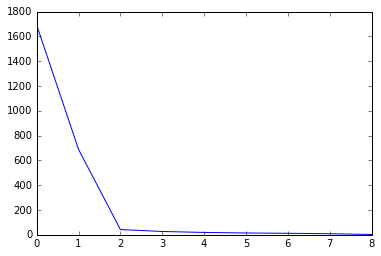

In [9]:
plt.plot(S)

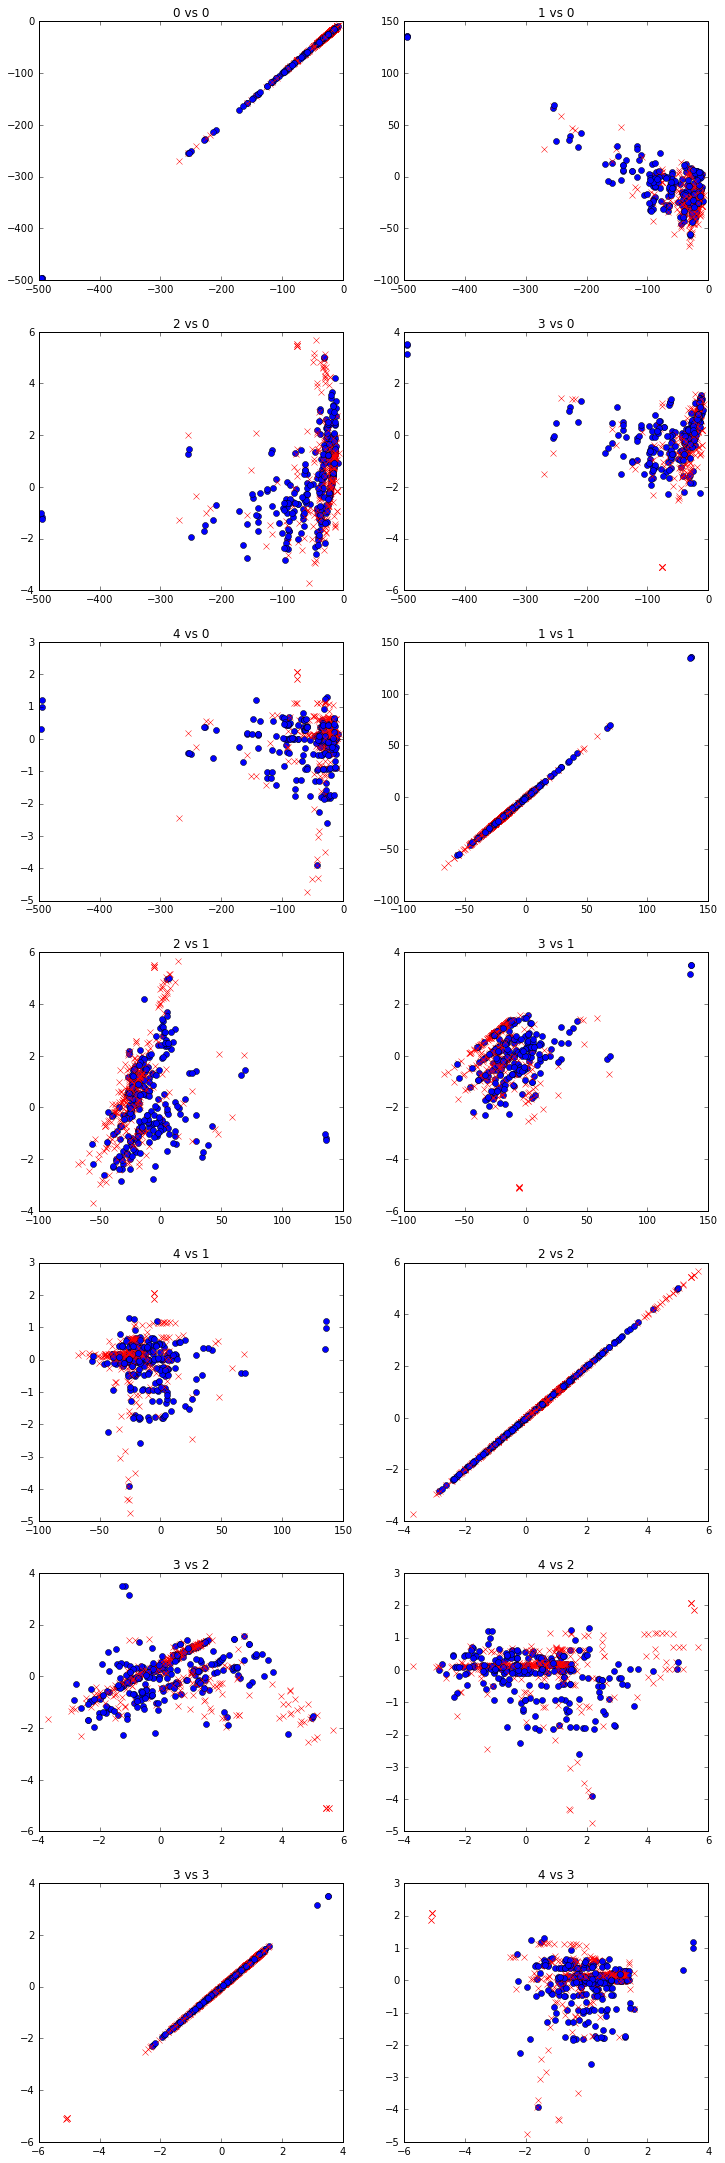

In [12]:
plt.figure(figsize=(12,38))
rank = 5
A_train_dr = (np.diag(S[0:rank])*Vt[0:rank,:]).T

plotNr = 1
for i in range(4):
    for j in range(5):
        if i > j:
            continue
        plt.subplot(7,2,plotNr)
        plotNr += 1
        plt.title(str(j) + ' vs ' + str(i))
        for k in range(len(A_train_dr)):
            if y_train[k,0] == 1 :
                plt.plot(A_train_dr[k,i],A_train_dr[k,j],'bo')
            else:
                plt.plot(A_train_dr[k,i],A_train_dr[k,j],'rx')

plt.show()

# Logistic Regression

In [13]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def LogError(y,pr,tresh):
    fn = 0
    fp = 0
    for i in range(len(y)):
        if (y[i,0] == 1.0 and pr[i,0] < tresh) :
            fn += 1
        elif (y[i,0] == 0.0 and pr[i,0] > tresh) :
            fp += 1

    return (fn/len(y),fp/len(y))

def LogErrorVTresh(y,pr):
    tresh = np.matrix(np.linspace(0.2,1,50)).T
    fn = np.zeros((len(tresh),1))
    fp = np.zeros((len(tresh),1))
    for i in range(len(tresh)):
        fn[i,0],fp[i,0] = LogError(y,pr,tresh[i,0])
    
    return (tresh,fn,fp)


In [14]:
w_lr = np.matrix(np.ones((A_train.shape[1],1)))
eta = 0.001

for i in range(100000):
    pr = sigmoid(A_train*w_lr)
    w_lr = w_lr + eta*A_train.T*(y_train-pr)
    
pr_train = sigmoid(A_train*w_lr)    
pr_cv = sigmoid(A_cv*w_lr)

(tresh,fn_train,fp_train) = LogErrorVTresh(y_train,pr_train)
(tresh,fn_cv,fp_cv) = LogErrorVTresh(y_cv,pr_cv)

Blue is False negative Red is false positive


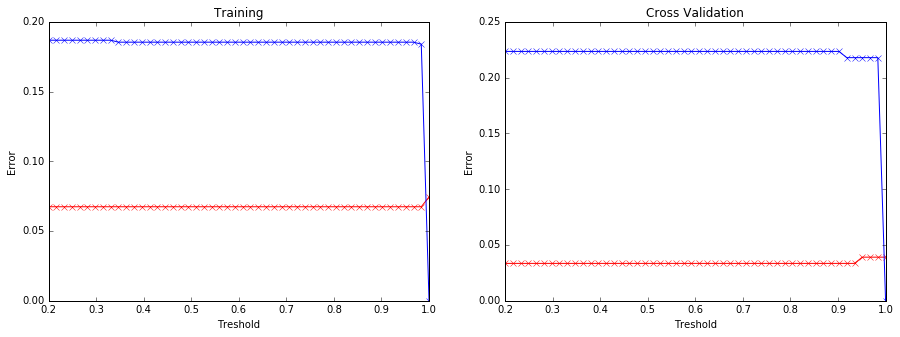

In [16]:
print('Blue is False negative Red is false positive')

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Training')
plt.plot(tresh,fn_train,"rx-")
plt.plot(tresh,fp_train,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.subplot(1,2,2)
plt.title('Cross Validation')
plt.plot(tresh,fn_cv,"rx-")
plt.plot(tresh,fp_cv,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.show()

#100.000 - 9/13 - 8/12
#10.000 - 6/18 - 6/15

In [17]:
y_test = sigmoid(A_test*w_lr)
for i in range(len(y_test)):
    if y_test[i] > 0.5 :
        y_test[i] = 1
    else:
        y_test[i] = 0
result = np.hstack((test_ids,y_test)).astype(int) #scored 0.71 on kaggle

In [18]:
w_lr = np.matrix(np.random.rand(A_all.shape[1],1))
eta = 0.001

for i in range(100000):
    pr = sigmoid(A_all*w_lr)
    w_lr = w_lr + eta*A_all.T*(y_all-pr)
    
y_test = sigmoid(A_test*w_lr)
for i in range(len(y_test)):
    if y_test[i] > 0.5 :
        y_test[i] = 1
    else:
        y_test[i] = 0
result = np.hstack((test_ids,y_test)).astype(int) #scored 0.73 on kaggle

# Logistic Regression with age and pclass


Blue is False negative Red is false positive


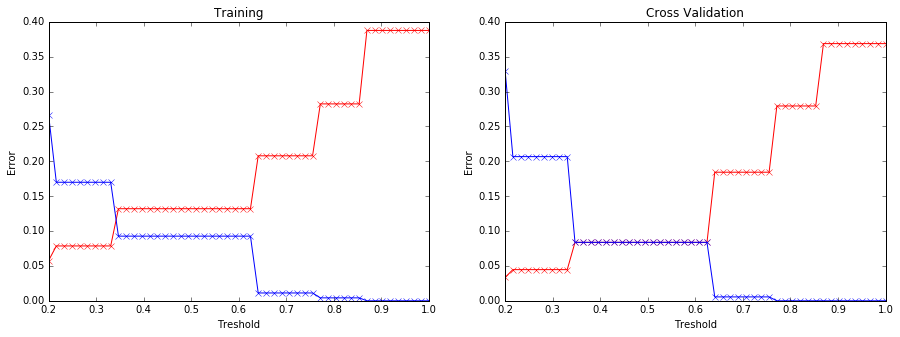

In [41]:
w_lr = np.matrix(np.ones((2,1)))
eta = 0.001

for i in range(100000):
    pr = sigmoid(A_train[:,0:2]*w_lr)
    w_lr = w_lr + eta*A_train[:,0:2].T*(y_train-pr)
    
pr_train = sigmoid(A_train[:,0:2]*w_lr)    
pr_cv = sigmoid(A_cv[:,0:2]*w_lr)

(tresh,fn_train,fp_train) = LogErrorVTresh(y_train,pr_train)
(tresh,fn_cv,fp_cv) = LogErrorVTresh(y_cv,pr_cv)

print('Blue is False negative Red is false positive')

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Training')
plt.plot(tresh,fn_train,"rx-")
plt.plot(tresh,fp_train,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.subplot(1,2,2)
plt.title('Cross Validation')
plt.plot(tresh,fn_cv,"rx-")
plt.plot(tresh,fp_cv,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.show()

# Logistic Regression on SVD data

Blue is False negative Red is false positive


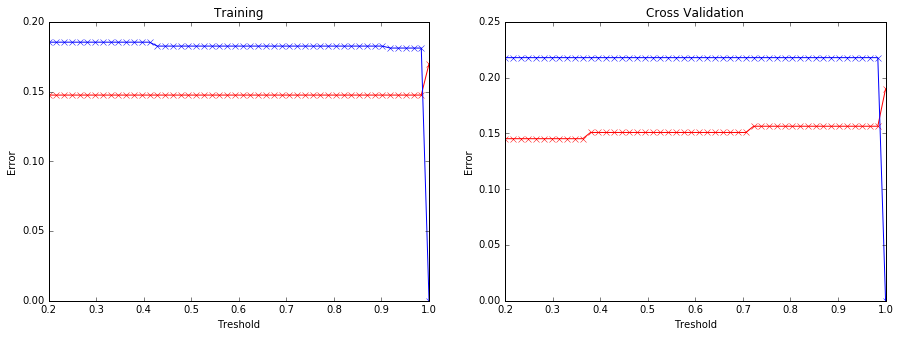

In [63]:
rank = 3
A_train_dr = (np.diag(S[0:rank])*Vt[0:rank,:]).T
A_cv_dr = (np.linalg.pinv(U[:,0:rank])*A_cv.T).T

w_lr = np.matrix(np.ones((rank,1)))
eta = 0.001

for i in range(100000):
    pr = sigmoid(A_train_dr*w_lr)
    w_lr = w_lr + eta*A_train_dr.T*(y_train-pr)
    
pr_train = sigmoid(A_train_dr*w_lr)    
pr_cv = sigmoid(A_cv_dr*w_lr)

(tresh,fn_train,fp_train) = LogErrorVTresh(y_train,pr_train)
(tresh,fn_cv,fp_cv) = LogErrorVTresh(y_cv,pr_cv)

print('Blue is False negative Red is false positive')

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Training')
plt.plot(tresh,fn_train,"rx-")
plt.plot(tresh,fp_train,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.subplot(1,2,2)
plt.title('Cross Validation')
plt.plot(tresh,fn_cv,"rx-")
plt.plot(tresh,fp_cv,"bx-")
plt.xlabel('Treshold')
plt.ylabel('Error')

plt.show()

# KNN

In [54]:
def NearestIndices(A,y,k,xInd):
    x = A[xInd,:]
    mins = [(np.inf,0) for _ in range(k)] #(dist,index)
    for i in range(len(A)):
        if i == xInd:
            continue
        dist = Distance(x,A[i,:])
        if dist < mins[0][0]:
            del mins[0]
            mins.append((dist,i))
            mins = sorted(mins,key = itemgetter(0),reverse = True)
    
    return [ind for dist,ind in mins]
    
def PredictWithIndices(y,inds):
    counter = 0.0
    for i in range(len(inds)):
        counter +=  y[inds[i],0] / len(inds)
    if counter > 0.5:
        return 1
    else:
        return 0

def ResultsForK(A,y,k):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for i in range(len(A)):
        inds = NearestIndices(A,y,k,i)
        pred = PredictWithIndices(y,inds)
        if y[i,0] == 1:
            if pred == 1:
                tp += 1
            else:
                fn += 1
        else:
            if pred == 1:
                fp += 1 
            else:
                tn += 1
    return tp,fp,tn,fn

def PlotResultVsK(A,y):
    kVals = [i+1 for i in range(20)]
    results = np.zeros((len(kVals),4))

    for i in kVals:
        tpk,fpk,tnk,fnk = ResultsForK(A,y,i)
        results[i-1,:] = np.matrix([tpk,fpk,tnk,fnk])
    
    accuracy = (results[:,0] + results[:,2]) / len(A)
    precision = results[:,0] / (results[:,0] + results[:,1])
    recall = results[:,0] / (results[:,0] + results[:,3])

    plt.plot(kVals,accuracy,'rx-')
    plt.plot(kVals,precision,'gx-')
    plt.plot(kVals,recall,'yx-')
    plt.text(1.2,0.95,'Accuracy',color='r')
    plt.text(1.2,0.90,'Precision',color='g')
    plt.text(1.2,0.85,'Recall',color='y')
    plt.ylim(0.5,1)

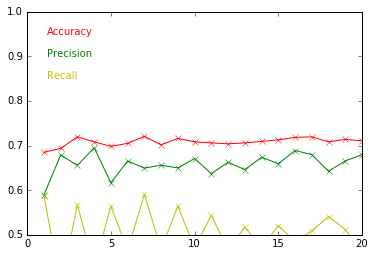

In [55]:
def Distance(x,y):
    dif = np.abs(x-y)
    return np.power(np.sum(np.power(dif,2)),1/2)

PlotResultVsK(A_all,y_all)